# Part 2: Heatwave analysis for Italy

# 1 Preliminaries: The temperature data for Italy

# Task 1.1: Extraction of ERA5 data for Italy
We'll use the Copernicus Climate Data Store (CDS) API to download temperature data at 2 meters altitude.

In [1]:
# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import cartopy
import cdsapi
# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

## Necessaries packages

In [4]:
filename = 'C:/Users/USER/OneDrive/Bureau/AMSE/Data_VIz_project/Italy_hourly_2015.nc'
ds = xr.open_dataset(filename)

da = ds['t2m']      # surface temp. at 2 meters
t2m_C = da - 273.15 # convert from Kelvin to Celsius
del ds, da

In [ ]:
# CDS API

DATADIR = 'C:/Users/USER/OneDrive/Bureau/AMSE/Data_VIz_project/'

## Get the Data
URLRequired='https://cds.climate.copernicus.eu/api'
KEY = 'ab8be67e-3964-4bbd-bfd9-ad1b1ab78bd8'

c = cdsapi.Client(url=URLRequired, key=KEY)
c.retrieve (
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'data_format': 'netcdf_legacy',
        'variable': '2m_temperature',
        'year': [
            '2015', '2016', '2017',
            '2018', '2019', '2020',
            '2021', '2022', '2023',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
         'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [46,9,37,18.5,],
    },
    f'{DATADIR}Italy_hourly_2015.nc')

# Task 1.2: Weekly aggregation and CSV export

In [5]:
# Load NetCDF data
ds = xr.open_dataset(filename)
#Extract temperature at 2m and convert to °C
ds["t2m"] = ds["t2m"] - 273.15

# Convert an DataFrame
df = ds["t2m"].to_dataframe().reset_index()

# Convert an datetime
df["time"] = pd.to_datetime(df["time"])
df["week"] = df["time"].dt.isocalendar().week
df["year"] = df["time"].dt.year

# Aggregation per week
df_weekly = df.groupby(["year", "week"])["t2m"].mean().reset_index()

# Save to  CSV
df_weekly.to_csv("italy_temperature_weekly.csv", index=False)
print(df_weekly)

     year  week        t2m
0    2015     1   8.340602
1    2015     2   9.507697
2    2015     3  10.645698
3    2015     4   9.500418
4    2015     5   7.616688
..    ...   ...        ...
467  2023    48  12.972022
468  2023    49   9.976119
469  2023    50  11.821820
470  2023    51  11.572938
471  2023    52  12.061117

[472 rows x 3 columns]


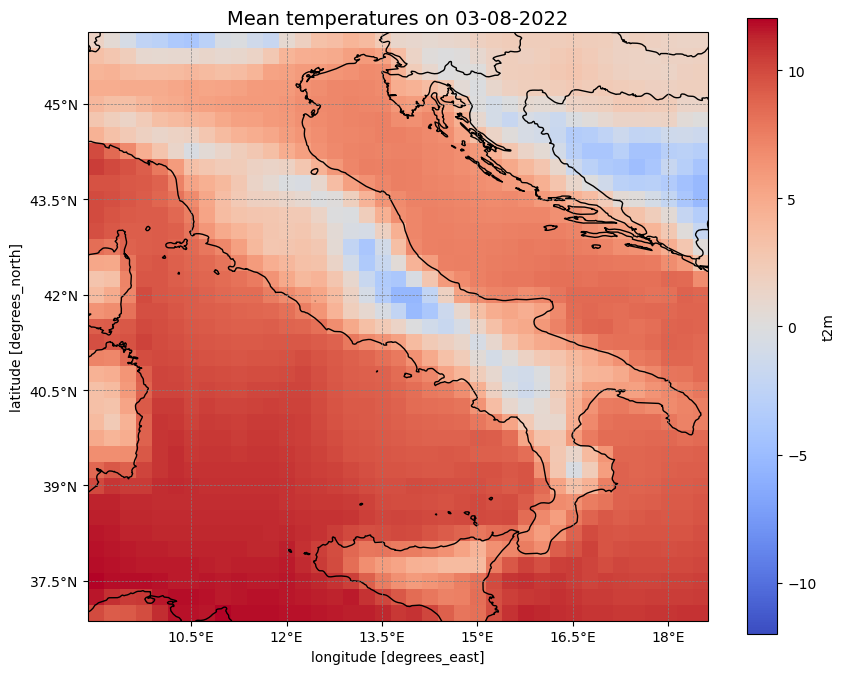

In [6]:
# Select one specific  date  (example : 3 août 2022)
date_selected = "03-08-2022"
temp_selected = ds["t2m"].sel(time=date_selected).mean(dim="time")
# figure creation
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Temperature map display
img = temp_selected.plot.imshow(
    ax=ax,
    cmap="coolwarm",  # Rouge = chaud, Bleu = froid
    interpolation="nearest",
    add_colorbar=True
)

# Adding borders and geographical details
ax.add_feature(cfeature.BORDERS, edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.LAND, edgecolor="black", facecolor="none")

# Adding graduations and grid
ax.set_xticks([10.5, 12, 13.5, 15, 16.5, 18], crs=ccrs.PlateCarree())
ax.set_yticks([37.5, 39, 40.5, 42, 43.5, 45], crs=ccrs.PlateCarree())

# Importation of  the necessary module for formatting ticks
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# Format ticks in degrees with the right style
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

# Adding a fine grid for better visualization
ax.grid(color='gray', linestyle="--", linewidth=0.5)

# Adding a title with the date
ax.set_title(f"Mean temperatures on {date_selected}", fontsize=14)

# show map
plt.show()

# Task 1.3: Visualization of temperature data for summer 2022


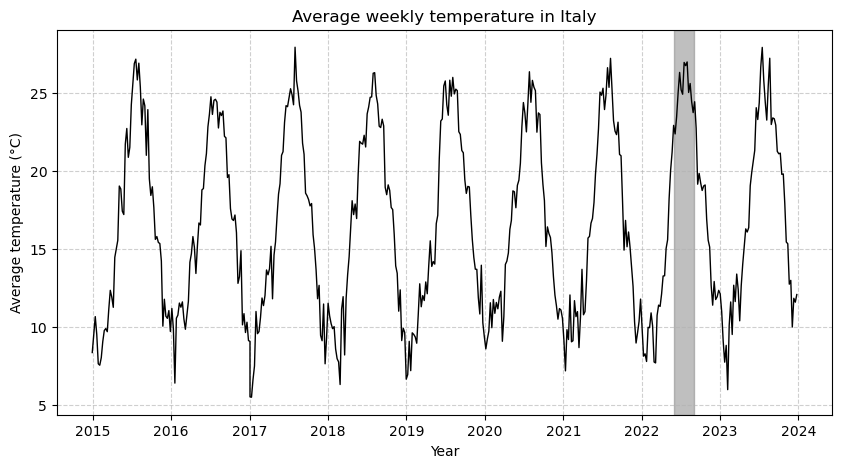

In [7]:
# load the data again
df = pd.read_csv("italy_temperature_weekly.csv")

# Convert 'year' and 'week' an format datetime
df["date"] = pd.to_datetime(df["year"].astype(str) + df["week"].astype(str) + '1', format="%G%V%w")

# Filter Summer 2022 (June to August)
summer_2022_start = pd.to_datetime("2022-06-01")
summer_2022_end = pd.to_datetime("2022-08-31")

# Creation of  graph
fig, ax = plt.subplots(figsize=(10, 5))

# time series plot
ax.plot(df["date"], df["t2m"], color="black", linewidth=1)

# Adding a gray stripe for summer 2022
ax.axvspan(summer_2022_start, summer_2022_end, color="gray", alpha=0.5)

# Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Average temperature (°C)")
ax.set_title("Average weekly temperature in Italy")

# display grid
ax.grid(True, linestyle="--", alpha=0.6)

# display  figure
plt.show()

## Mortality data

## Download data 

In [8]:
# Download and load the data
url = "https://raw.githubusercontent.com/akarlinsky/world_mortality/main/world_mortality.csv"
df = pd.read_csv(url)

# filter only for italy
df_italy = df[df["iso3c"] == "ITA"].copy()

# drop the non necessarie colums
df_italy = df_italy.drop(columns=["iso3c", "country_name", "time_unit"])

# Rename the  colomns
df_italy = df_italy.rename(columns={"deaths": "mortality", "time": "week"})

# Convert year + week an  a true data
df_italy["start_date"] = pd.to_datetime(df_italy["year"].astype(str) + df_italy["week"].astype(str) + '1', format="%G%V%w")

# display the data
print(df_italy.head())

# Save the data
df_italy.to_csv("italy_mortality.csv", index=False)

       year  week  mortality start_date
15649  2015     1    15178.0 2014-12-29
15650  2015     2    15811.0 2015-01-05
15651  2015     3    15480.0 2015-01-12
15652  2015     4    14922.0 2015-01-19
15653  2015     5    15228.0 2015-01-26


# 3 - A simple time-series model of excess mortality


## Total number of excess deaths in Italy in summer of 2022: 26773.25


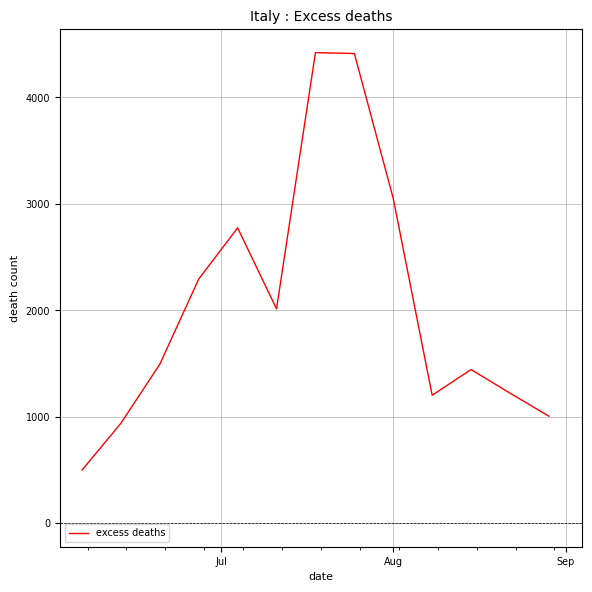

In [9]:
# Download and load the data
url = "https://raw.githubusercontent.com/akarlinsky/world_mortality/main/world_mortality.csv"
df = pd.read_csv(url)

# Filter Italy only
df_italy = df[df["iso3c"] == "ITA"].copy()
df_italy = df_italy.rename(columns={'deaths': 'mortality', 'week': 'time'})

# Create data variable
df_italy['date'] = pd.to_datetime(df_italy['year'].astype(str) + '-W' + df_italy['time'].astype(str) + '-1', format='%Y-W%W-%w')

# Filter data before 2020-03-01 for model estimation
df_pre_2020 = df_italy[df_italy['date'] < pd.to_datetime('2020-03-01')].copy()

# Creating variables for modeling
df_pre_2020['year_num'] = df_pre_2020['year'] - df_pre_2020['year'].min() # Numeric year variable
df_pre_2020['week_categorical'] = pd.Categorical(df_pre_2020['time']) # Categorical variable for the week

# Estimation of model
formula = 'mortality ~ year_num + week_categorical'
model = smf.ols(formula, data=df_pre_2020).fit()

# Prepare the data for the  prediction (été 2022)
start_date_2022_summer = pd.to_datetime('2022-06-02')  # Slightly earlier
end_date_2022_summer = pd.to_datetime('2022-09-04')    # Slightly later
df_2022_summer = df_italy[(df_italy['date'] >= start_date_2022_summer) & (df_italy['date'] <= end_date_2022_summer)].copy()
df_2022_summer['year_num'] = df_2022_summer['year'] - df_pre_2020['year'].min()
df_2022_summer['week_categorical'] = pd.Categorical(df_2022_summer['time'], categories=df_pre_2020['week_categorical'].cat.categories)

# Predicting mortality for summer 2022
predictions_2022_summer = model.predict(df_2022_summer)

# Calculate excess mortality for summer 2022
excess_mortality_2022_summer = df_2022_summer['mortality'] - predictions_2022_summer
total_excess_mortality_2022_summer = excess_mortality_2022_summer.sum()
print(f"\n## Total number of excess deaths in Italy in summer of 2022: {total_excess_mortality_2022_summer:.2f}")

# Plotting excess mortality specifically for summer 2022
plt.figure(figsize=(6, 6))
plt.plot(df_2022_summer['date'], excess_mortality_2022_summer, label='excess deaths', color='red', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('date', fontsize=8)
plt.ylabel('death count', fontsize=8)
plt.title('Italy : Excess deaths', fontsize=10)
plt.xlim(start_date_2022_summer, end_date_2022_summer)

# Adjust x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=(1)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)

plt.legend(loc='lower left', fontsize=7)
plt.grid(True, linewidth=0.5)
plt.tight_layout(pad=1.0)
plt.show()

## 4-The relationship between mortality and temperature

In [10]:
# loading the data
df_temp = pd.read_csv("italy_temperature_weekly.csv")
df_mort = pd.read_csv("italy_mortality.csv")

# Merge on year + week
df_combined = pd.merge(df_temp, df_mort, on=['year', 'week'])

# Delete rows with missing values
df_combined = df_combined.dropna()

df_combined.head(10)


,year,week,t2m,mortality,start_date
0,2015,1,8.340602,15178.0,2014-12-29
1,2015,2,9.507697,15811.0,2015-01-05
2,2015,3,10.645698,15480.0,2015-01-12
3,2015,4,9.500418,14922.0,2015-01-19
4,2015,5,7.616688,15228.0,2015-01-26
5,2015,6,7.526555,15640.0,2015-02-02
6,2015,7,8.009042,15510.0,2015-02-09
7,2015,8,9.041834,15149.0,2015-02-16
8,2015,9,9.751206,14544.0,2015-02-23
9,2015,10,9.878195,14211.0,2015-03-02


In [11]:
df_combined.to_csv("C:/Users/USER/OneDrive/Bureau/AMSE/Data_VIz_project/combined.csv", index=False, encoding='utf-8')

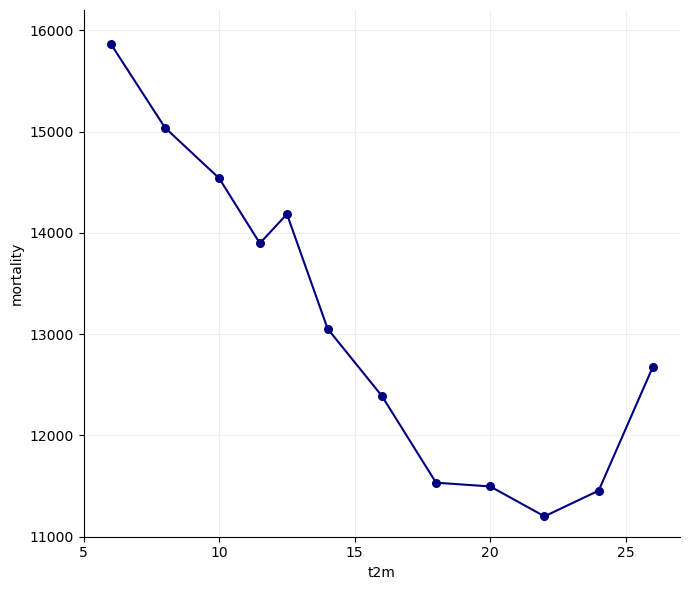

In [12]:
# Chargement des données
temp_data = pd.read_csv("italy_temperature_weekly.csv")
mortality_data = pd.read_csv("italy_mortality.csv")

# Préparation des données
temp_data['date_key'] = temp_data['year'].astype(str) + '-' + temp_data['week'].astype(str).str.zfill(2)
mortality_data['date_key'] = mortality_data['year'].astype(str) + '-' + mortality_data['week'].astype(str).str.zfill(2)

# Fusion des données
merged_data = pd.merge(mortality_data, temp_data, on='date_key', suffixes=('_mort', '_temp'))

# Création des intervalles de température spécifiques pour correspondre à l'image
bins = [5, 7, 9, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27]
merged_data['temp_bin'] = pd.cut(merged_data['t2m'], bins=bins)

# Calcul des moyennes par intervalle
bin_stats = merged_data.groupby('temp_bin', observed=False)['mortality'].mean().reset_index()

# Calcul des points médians des intervalles pour l'axe x
bin_midpoints = [(interval.left + interval.right)/2 for interval in bin_stats['temp_bin']]

# Création du graphique
plt.figure(figsize=(7, 6))

# Tracer les points
plt.scatter(bin_midpoints, bin_stats['mortality'], color='navy', s=30, zorder=3)

# Tracer les segments de ligne avec des discontinuités
# Pour créer l'effet des segments discontinus que l'on voit dans l'image 2
for i in range(len(bin_midpoints)-1):
    # Seulement si les points ne sont pas trop éloignés (pour créer la discontinuité)
    if abs(bin_midpoints[i+1] - bin_midpoints[i]) < 2.5:  # Seuil pour créer la discontinuité
        plt.plot([bin_midpoints[i], bin_midpoints[i+1]], 
                [bin_stats['mortality'].iloc[i], bin_stats['mortality'].iloc[i+1]], 
                '-', color='navy', linewidth=1.5, zorder=2)

# Configuration des axes et de la grille
plt.grid(True, linestyle='-', alpha=0.2)
plt.xlim(5, 27)
plt.ylim(11000, 16200)

# Définir les graduations de l'axe x par bonds de 5
plt.xticks([5, 10, 15, 20, 25])

plt.xlabel('t2m')
plt.ylabel('mortality')

# Supprimer les bordures du haut et de droite
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajuster l'espacement
plt.tight_layout()

# Sauvegarder le graphique
plt.savefig('mortalite_temperature_relation.png', dpi=300)

plt.show()